In [101]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
sys.path.append('../')  # Add parent dir to path
import hardware
from scipy.spatial.transform import Rotation as R

In [102]:
def mjd_to_hours(mjd):
    seconds_per_day = 86400  # 24 hours * 60 minutes * 60 seconds
    mjd_epoch = 2400000.5  # JD of MJD
    
    # MJD --> JD
    jd = mjd + mjd_epoch
    
    # JD --> hrs since start
    hours_since_start = (jd - jd.iloc[0]) * 24
    
    return hours_since_start

def cart_to_alt_az(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    # az in rad
    theta = np.arctan2(y, x)  # arctan2 handles the correct quadrant of the angle
    # pol angle
    phi = np.arccos(z / r)
    # polar angle to altitude in degrees
    alt = np.degrees(np.pi/2 - phi)  # pi/2 - phi to convert polar angle to altitude
    # az to deg
    az = np.degrees(theta)
    return alt, az

In [103]:
class Sun_mr:
      def __init__(self,alt,az,hrs):
            horizon = 0.0
            to_rad  = np.pi/180
            sun_rad = 0.265*to_rad
            self.radius = 0.265*to_rad
          
            self.alt = alt
            self.az = az
            sun = np.zeros((len(alt),3))
            sun[:,0] = np.cos(self.alt) * np.sin(self.az)
            sun[:,1] = np.cos(self.alt) * np.cos(self.az)
            sun[:,2] = np.sin(self.alt)
          
            self.condition =  [self.alt>horizon+self.radius, self.alt>horizon, self.alt>horizon-self.radius, self.alt<=horizon-self.radius]
            self.xyz = sun
            self.hrs = hrs

In [104]:
class Panel: # base, "abstract"

    name            ='Base Panel Class' # will be overwritten in the derived classes
    verbose         = True
    solarConstant   = 1361   # W/m^2 at Moon 

    ###
    def __init__(self, sun, name = '', lander=(0.0 , 0.0, 0.0), normal=(None, None, None), env=None, area=1.0, pvEFF_T=None, pvEFF_P=None, efficiency_mult=1.0, apply_cosine_correction=True, temperatures = None):

        lander_pitch, lander_roll, lander_yaw = lander
        

        r1 = R.from_euler('x', lander_pitch,    degrees=True) # + is nose down,     - is nose up
        r2 = R.from_euler('y', lander_roll,     degrees=True) # + is top left,      - is top right
        r3 = R.from_euler('z', lander_yaw,      degrees=True) # + is nose right,    - is nose left
        self.r_tot = r1*r2*r3

        self.sun        = sun
        self.name       = name
        self.area       = area
        self.env        = env
        self.efficiency_mult = efficiency_mult
        self.apply_cosine_correction = apply_cosine_correction
        self.temperature = temperatures
        #self.regolith_temperature
        

        if pvEFF_T is not None: 
            self.pvEfficiency = Panel.pvEfficiency
        else:
            self.pvEfficiency = np.polyfit(pvEFF_T, pvEFF_P, 2)
        
        # The "normal" is specific to each of the three (or more) subclassed panels
        self.normal     = normal
        self.normal_rot = self.r_tot.apply(self.normal)
        self.dot_sun    = self.dot(self.sun.xyz)
        self.dot_sun_corr = self.pv_angle_corr(self.sun.xyz)

        self.choice_list = [self.dot_sun, self.dot_sun, 0, 0]
        self.condition_list = self.sun.condition
    
    ### ---
    def dot(self, sun_xyz):
        buffer = self.area*np.dot(sun_xyz, self.normal_rot)
        buffer[buffer<0] = 0.0
        return buffer

    ### ---
    def pv_angle_corr(self, sun_xyz):
        #Correction factor for measured divergence of PV power as a function of solar angle from expected cosine/dot-product dependence 
        #Correction function derived from measured PV data in Ben Saliwanchik's lusee_pv_cosine_angle_correction.ipynb
        
        sun_unit = sun_xyz / np.linalg.norm(sun_xyz, axis=1)[:, np.newaxis] #Unit vector for direction of sun
        pv_unit = self.normal_rot / np.linalg.norm(self.normal_rot) #PV normal_rot should already be a unit vector, but hey, safety first!
        sun_angle = np.abs(np.degrees(np.arccos(np.dot(sun_unit, pv_unit)))) #Angle between sun and PV normal vector

        #Correction is modeled as high-order polynomial based on measured PV power as a function of angle
        poly_coeffs = [1.0004983419956408e+000, -3.8502838956781440e-003, 1.7502375769223580e-003, -3.5217013489873119e-004, 3.5446614736203286e-005, -2.0316555216327750e-006, \
                   7.1799275885981016e-008, -1.6233764365292121e-009, 2.3567637664937247e-011, -2.1265570389995531e-013, 1.0858756530544471e-015, -2.3977629606594377e-018]
        poly_fit = np.polynomial.Polynomial(poly_coeffs)

        return poly_fit(sun_angle)  
    
    ### ---
    def set_condition(self, condition_list):
        self.condition_list = condition_list

    ### ---
    def exposure(self):
        pwr = np.select(self.condition_list, self.choice_list)
        return pwr
    
    ### ---
    def power(self):
        eff = 0.3
        power = 0
        if self.temperature is not None:
            eff = self.pvEfficiency(self.temperature) 
            if self.apply_cosine_correction:
                power =  Panel.solarConstant*eff*np.select(self.condition_list, self.choice_list)*self.dot_sun_corr * self.efficiency_mult
                print(power)
            else:
                power =  Panel.solarConstant*eff*np.select(self.condition_list, self.choice_list) * self.efficiency_mult
        return power
    
    ### ---
    def info(self):
        return f'''Panel {self.name}'''
    
    ### Static method for the PV efficiency calculation (just convenient)
    @staticmethod
    def pvEfficiency(temperatures):
        pvTemp = np.array([-173.15, 20, 126.85])
        pvPwr = np.array([152, 130, 110]) / 426.47  # Stated AM0 normal incidence power output of top panel
        p = np.poly1d(np.polyfit(pvTemp, pvPwr, 2))
        return p(temperatures)

# ------------------------------------------------------------


In [105]:
config = yaml.safe_load(open('../config/devices.yml','r'))
pcf= config['solar_panels']['config'] # panel config
panels  = config['solar_panels']['panels'] # list of panels
lander = np.array([float(x) for x in pcf['lander'].split()])
pvEFF_T = np.array([float(x) for x in pcf['PV_efficiency']['temp'].split()])
pvEFF_P = np.array([float(x) for x in pcf['PV_efficiency']['power'].split()])

# Loading in solar panel from Opsim

In [106]:
sol_pvt = pd.read_csv('sol_pow_RevA.csv',delimiter=',') ## loading in solar power data, from opsim
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['Time (mjd)'])
sol_pvt['alt'],sol_pvt['az']= cart_to_alt_az(sol_pvt['Solar X'], sol_pvt['Solar Y'], sol_pvt['Solar Z'])

In [107]:
temperature_panel= np.zeros((len(sol_pvt['Panel E Temp']),3))
temperature_panel[:,0] = sol_pvt['Panel E Temp'] + 273.15
temperature_panel[:,1] = sol_pvt['Panel W Temp']   + 273.15
temperature_panel[:,2] = sol_pvt['Panel Top Temp']  + 273.15
sun = Sun_mr(sol_pvt['alt'],sol_pvt['az'],sol_pvt['sol_hrs'])

In [115]:
panel_list_opsim = []
for panel_name,i in zip(panels, range(len(panels))):
    panel = panels[panel_name]
    print(panel)
    normal = np.array([float(x) for x in panel['normal'].split()])
    eff = panel['efficiency']*pcf['efficiency_all']
    panel = Panel(sun, name = '', lander=(0.0 , 0.0, 0.0), normal=normal, env=None, area=1.0, pvEFF_T= pvEFF_T, pvEFF_P=pvEFF_P , efficiency_mult=1.0, apply_cosine_correction=True, temperatures= temperature_panel[:,i])
    panel_list_opsim.append(panel)
print(panel_list_ryan[0].power())

{'normal': '1 0 0', 'efficiency': 1.0, 'area': 0.1565}
{'normal': '-1 0 0', 'efficiency': 1.0, 'area': 0.1565}
{'normal': '0 0 1', 'efficiency': 1.0, 'area': 0.313}
[-0.         -0.         -0.         ... 30.34174852 -0.
 -0.        ]
[-0.         -0.         -0.         ... 30.34174852 -0.
 -0.        ]


[-0. -0. -0. ...  0. -0. -0.]
[ 0.  0.  0. ... -0.  0.  0.]
[-0. -0. -0. ... -0. -0. -0.]


Text(0.02, 0.5, 'P (watts)')

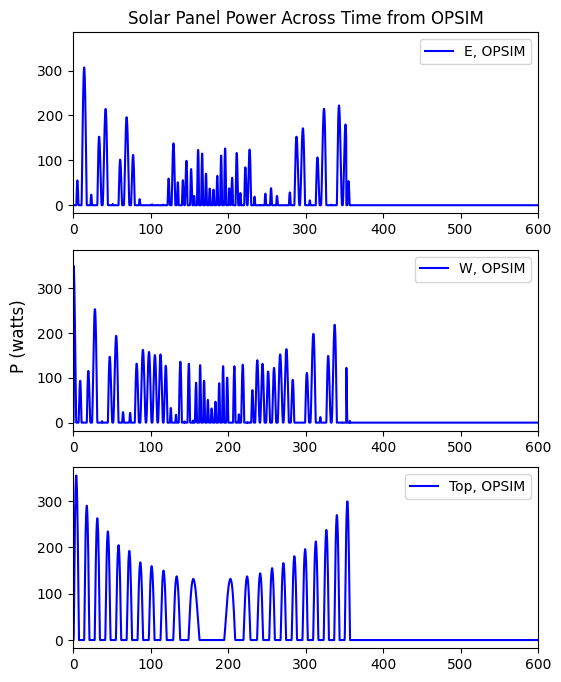

In [109]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(3, 1, 1)
plt.title('Solar Panel Power Across Time from OPSIM')
plt.plot(sol_pvt['sol_hrs'],  panel_list_opsim[0].power(), color ='blue' ,label='E, OPSIM')
plt.xlim(0,600)

plt.legend()
plt.subplot(3, 1, 2)
plt.plot(sol_pvt['sol_hrs'], panel_list_opsim[1].power(), color ='blue' ,label='W, OPSIM')
plt.xlim(0,600)

plt.legend()
plt.subplot(3, 1, 3)
plt.plot(sol_pvt['sol_hrs'],  panel_list_opsim[2].power(), color ='blue' ,label='Top, OPSIM')
plt.xlim(0,600)
plt.legend()


plt.legend()
fig.supylabel('P (watts)')



# Reading solar panel model -- Ryan

In [110]:
sol_ryan = pd.read_csv('Night1_SolarPanels_354hrEclipse_240725.csv',delimiter=',') 
sol_ryan = sol_ryan.T ## flips
sol_ryan = sol_ryan.reset_index(drop=True) ## sets col
sol_ryan.columns = sol_ryan.iloc[0] ## sets col
sol_ryan = sol_ryan.drop(0) ## reindex

sol_ryan = sol_ryan[['Dir/Times','SOLAR_PNL_MX_AVG','SOLAR_PNL_PX_AVG','SOLAR_PNL_PZ_AVG','SOLAR_X','SOLAR_Y','SOLAR_Z']]
sol_ryan = sol_ryan[0:2550]
#print(sol_ryan)

for column in sol_ryan.columns:
    sol_ryan[column] = sol_ryan[column].astype(float)

sol_ryan['alt'],sol_ryan['az']= cart_to_alt_az(sol_ryan['SOLAR_X'], sol_ryan['SOLAR_Y'], sol_ryan['SOLAR_Z'])
#print(sol_ryan)

In [111]:
temperature_panel_ryan= np.zeros((len(sol_ryan['SOLAR_PNL_MX_AVG']),3))
temperature_panel_ryan[:,0] = sol_ryan['SOLAR_PNL_MX_AVG'] + 273.15
temperature_panel_ryan[:,1] = sol_ryan['SOLAR_PNL_PX_AVG'] + 273.15
temperature_panel_ryan[:,2] = sol_ryan['SOLAR_PNL_PZ_AVG'] + 273.15

sun = Sun_mr(sol_ryan['alt'],sol_ryan['az'],sol_ryan['Dir/Times'])

In [112]:
panel_list_ryan = []
for panel_name,i in zip(panels, range(len(panels))):
    panel = panels[panel_name]
    print(panel)
    normal = np.array([float(x) for x in panel['normal'].split()])
    eff = panel['efficiency']*pcf['efficiency_all']
    panel = Panel(sun, name = '', lander=(0.0 , 0.0, 0.0), normal=normal, env=None, area=1.0, pvEFF_T= pvEFF_T, pvEFF_P=pvEFF_P , efficiency_mult=1.0, apply_cosine_correction=True, temperatures= temperature_panel_ryan[:,i])
    panel_list_ryan.append(panel)
print(panel_list_ryan[0].power())

{'normal': '1 0 0', 'efficiency': 1.0, 'area': 0.1565}
{'normal': '-1 0 0', 'efficiency': 1.0, 'area': 0.1565}
{'normal': '0 0 1', 'efficiency': 1.0, 'area': 0.313}
[-0.         -0.         -0.         ... 30.34174852 -0.
 -0.        ]
[-0.         -0.         -0.         ... 30.34174852 -0.
 -0.        ]


[-0. -0. -0. ...  0. -0. -0.]
[-0.         -0.         -0.         ... 30.34174852 -0.
 -0.        ]
[ 0.  0.  0. ... -0.  0.  0.]
[190.15313387 198.26786544 184.36495486 ...  -0.          24.80747904
  80.37899602]
[-0. -0. -0. ...  0. -0. -0.]
[-0. -0. -0. ... -0. -0. -0.]


Text(0.5, 0, 'Time (hrs)')

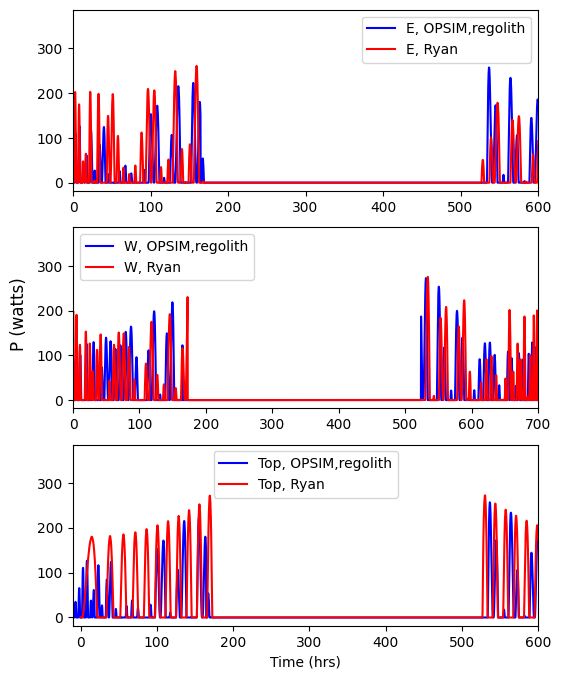

In [114]:
sunset = 188  ### adjustable time

fig =plt.figure(figsize=(6, 8))
#plt.title('Solar Panel Power Across Time Comparing Opsim and Ryan')
plt.subplot(3, 1, 1)
plt.plot(sol_pvt['sol_hrs'] - sunset,   panel_list_opsim[0].power(), color ='blue' ,label='E, OPSIM,regolith')
plt.plot(sol_ryan['Dir/Times'],  panel_list_ryan[0].power(), color ='red' ,label='E, Ryan')

plt.xlim(0,600)

plt.legend()
plt.subplot(3, 1, 2)
plt.plot(sol_pvt['sol_hrs']- sunset,   panel_list_opsim[1].power(), color ='blue' ,label='W, OPSIM,regolith')
plt.plot(sol_ryan['Dir/Times'],  panel_list_ryan[1].power(), color ='red' ,label='W, Ryan')
plt.xlim(0,700)

plt.legend()
plt.subplot(3, 1, 3)
plt.plot(sol_pvt['sol_hrs']- sunset,   panel_list_opsim[0].power(), color ='blue' ,label='Top, OPSIM,regolith')
plt.plot(sol_ryan['Dir/Times'],  panel_list_ryan[2].power(), color ='red' ,label='Top, Ryan')
plt.xlim(-10,600)
plt.legend()


plt.legend()
fig.supylabel('P (watts)')
plt.xlabel('Time (hrs)')



## Sanity Checks (alt, az etc)

Text(0.02, 0.5, 'Degrees')

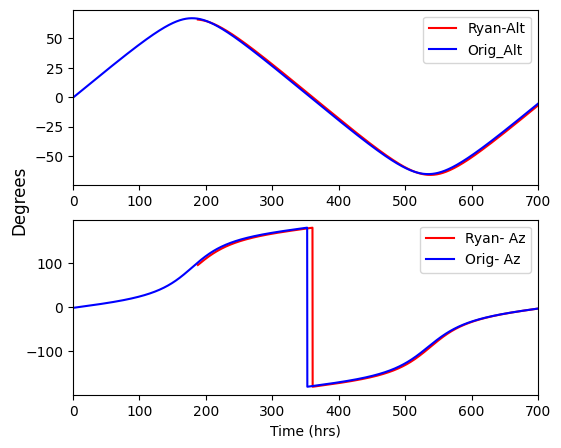

In [21]:
sunset = 188 ### adjustable

fig =plt.figure(figsize=(6, 5))
plt.subplot(2, 1, 1)
plt.plot(sol_ryan['Dir/Times']+sunset,  sol_ryan['alt'], color ='red' ,label='Ryan-Alt')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['alt'], color ='blue' ,label='Orig_Alt')
plt.xlim(0,700)

plt.legend()
plt.subplot(2, 1, 2)
plt.plot(sol_ryan['Dir/Times']+sunset,  sol_ryan['az'], color ='red' ,label='Ryan- Az')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['az'], color ='blue' ,label='Orig- Az')
plt.xlim(0,700)
plt.xlabel('Time (hrs)')
plt.legend()
fig.supylabel('Degrees')

Text(0.02, 0.5, 'Position (X Y or Z in rad)')

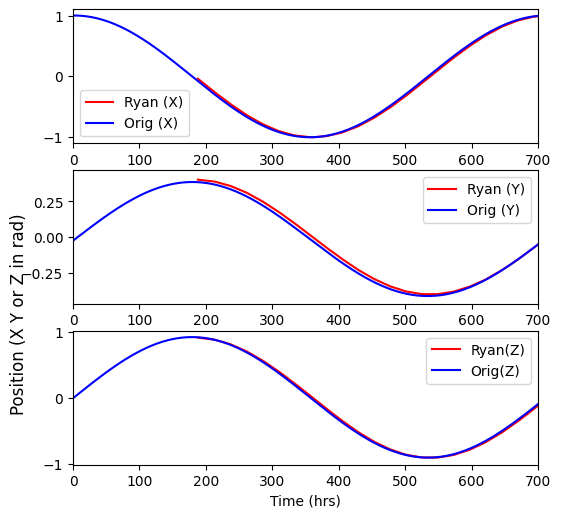

In [15]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(4, 1, 1)
plt.plot(sol_ryan['Dir/Times']+sunset, sol_ryan['SOLAR_X'], color ='red' ,label='Ryan (X)')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar X'], color ='blue' ,label='Orig (X)')
plt.xlim(0,700)

plt.legend()
plt.subplot(4, 1, 2)
plt.plot(sol_ryan['Dir/Times']+sunset,  sol_ryan['SOLAR_Y'], color ='red' ,label='Ryan (Y)')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar Y'], color ='blue' ,label='Orig (Y)')
plt.xlim(0,700)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sol_ryan['Dir/Times']+sunset,  sol_ryan['SOLAR_Z'], color ='red' ,label='Ryan(Z)')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar Z'], color ='blue' ,label='Orig(Z)')
plt.xlabel('Time (hrs)')
plt.xlim(0,700)
plt.legend()
fig.supylabel('Position (X Y or Z in rad)')


#fig.supylabel('Alt (degrees)')

### Opsim power plot

Text(0.02, 0.5, 'P (watts)')

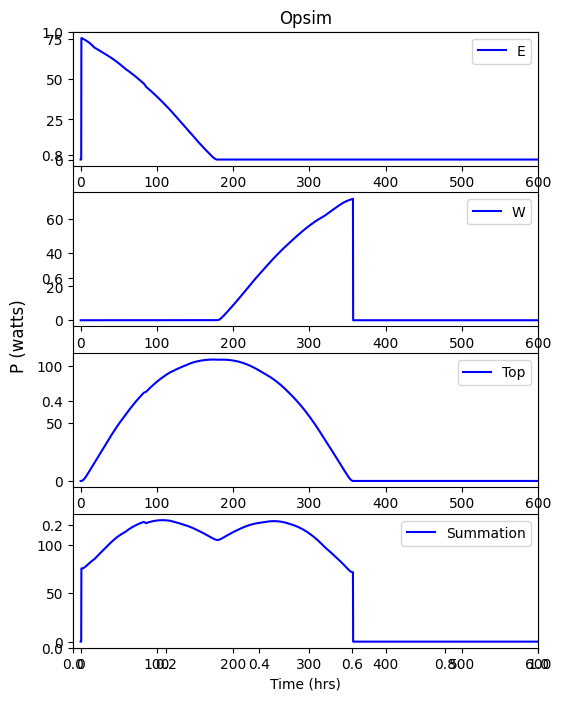

In [16]:
fig =plt.figure(figsize=(6, 8))
plt.title('Opsim')
plt.subplot(4, 1, 1)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel E Power'], color ='blue' ,label='E')
plt.xlim(-10,600)

plt.legend()
plt.subplot(4, 1, 2)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel W Power'], color ='blue' ,label='W')
plt.xlim(-10,600)

plt.legend()
plt.subplot(4, 1, 3)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel Top Power'], color ='blue' ,label='Top')
plt.xlim(-10,600)

plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar power (watts)'], color ='blue' ,label='Summation')
plt.xlim(-10,600)
plt.xlabel('Time (hrs)')
plt.legend()
fig.supylabel('P (watts)')



### Ryan and Opsim temp plots

Text(0.02, 0.5, 'Temperature (C)')

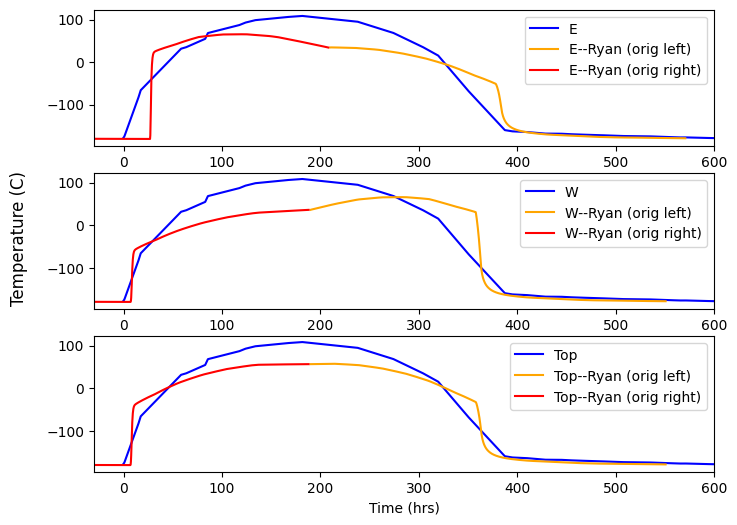

In [97]:
fig =plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel E Temp'], color ='blue' ,label='E')
plt.plot(sol_ryan['Dir/Times'][0:1300]+210,  sol_ryan['SOLAR_PNL_MX_AVG'][0:1300], color ='orange' ,label='E--Ryan (orig left)')
plt.plot(sol_ryan['Dir/Times'][1300:]-500,  sol_ryan['SOLAR_PNL_MX_AVG'][1300:], color ='red' ,label='E--Ryan (orig right)')
plt.xlim(-30,600)
#plt.ylabel('P (watts)')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel W Temp'], color ='blue' ,label='W')
plt.plot(sol_ryan['Dir/Times'][0:1300]+190,  sol_ryan['SOLAR_PNL_PX_AVG'][0:1300], color ='orange' ,label='W--Ryan (orig left)')
plt.plot(sol_ryan['Dir/Times'][1300:]-520,  sol_ryan['SOLAR_PNL_PX_AVG'][1300:], color ='red' ,label='W--Ryan (orig right)')
plt.xlim(-30,600)
#plt.ylabel('P (watts)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel Top Temp'], color ='blue' ,label='Top')
plt.plot(sol_ryan['Dir/Times'][0:1300]+190,  sol_ryan['SOLAR_PNL_PZ_AVG'][0:1300], color ='orange' ,label='Top--Ryan (orig left)')
plt.plot(sol_ryan['Dir/Times'][1300:]-520,  sol_ryan['SOLAR_PNL_PZ_AVG'][1300:], color ='red' ,label='Top--Ryan (orig right)')
plt.xlabel('Time (hrs)')
plt.xlim(-30,600)
plt.legend()
fig.supylabel( 'Temperature (C)')
